# SA-CCR analytical app
\[_In case you’re unable to see the atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/notebooks/blob/master/notebooks/sa-ccr/main.ipynb)._]

This notebook provides a reference implementation of interactive analytical app for SA-CCR analytics in python using Jupyter Notebook and [atoti](https://www.atoti.io).

<img src=./app-preview.gif/ width = 70%>

As a quick reminder, the SA-CCR is a regulatory methodology for computing EAD (Exposure At Default) which is part of the consolidated basel framework. It is already implemented for financial institutions in Europe by the Regulation (EU) 2019/876 (CRR II) and will be applicable from June 2021 and January 2022 in the US. In this post, I will walk you through code snippets implementing calculations as defined in the BCBS 279 document.

<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=saccr" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover.png" alt="atoti table" /></a></div>

We'll start by creating an atoti app, then we'll load sample data and implement chains of calculations aggregating EAD from trades, collateral and supervisory parameters on-the-fly. This chart is summarizing the calculation chains:

<img src=./SA-CCR.svg/ width = 50%>

We will be referring to the relevant paragraphs of the Consolidated Basel Framework [CRE52](https://www.bis.org/basel_framework/chapter/CRE/52.htm?inforce=20191215) - see numbers in the square brackets.

In [1]:
import atoti as tt
import pandas as pd

In [2]:
pd.set_option("display.max_rows", 30)
pd.set_option("display.max_columns", 100)
pd.options.display.float_format = "{:,.2f}".format

# Launch atoti

In [3]:
session = tt.Session(user_content_storage="./content")
session.link()

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

## Input data

In this section we will load the data used by the EAD aggregation into in-memory tables and start creating a cube. The sample data will be fetched from csv files hosted on s3, and you can replace them with your own sources.

- `trades_table` with information on the trades, books, notionals, market values, classified into asset classes. The time period parameter dates - Mi, Ei, Si and Ti [52.31] - are also provided in this file/
- `nettingSets_table` providing netting set attributes, for instance, the MPOR and collateral
- `supervisoryParameters_table` - values set in section [52.72] "Supervisory specified parameters".

In [4]:
trades_table = session.read_csv(
    "s3://data.atoti.io/notebooks/sa-ccr/T0/trades.csv",
    keys=["AsOfDate", "TradeId"],
    types={
        "Notional": tt.type.DOUBLE,
        "MarketValue": tt.type.DOUBLE,
        "AsOfDate": tt.type.LOCAL_DATE,
        "Mi_Date": tt.type.LOCAL_DATE,
        "Si_Date": tt.type.LOCAL_DATE,
        "Ti_Date": tt.type.LOCAL_DATE,
        "Ei_Date": tt.type.LOCAL_DATE,
    },
    table_name="Trades",
)
trades_table.head(3)

NettingSetId BookId  Direction      Notional  \
AsOfDate   TradeId                                                
2020-01-13 t428             EX9  Book7         -1  2,000,000.00   
           t72              EX2  Book1          1 27,000,000.00   
           t251             EX6  Book0         -1      5,200.00   

                      MarketValue AssetClass     SubClass OptionType  \
AsOfDate   TradeId                                                     
2020-01-13 t428        -70,000.00         FX  No SubClass        N/A   
           t72          73,000.00         IR  No SubClass          C   
           t251    -30,340,000.00      EQ_SN  No SubClass        N/A   

                   Underlying    Si_Date    Ei_Date    Mi_Date    Ti_Date  \
AsOfDate   TradeId                                                          
2020-01-13 t428        JPYGBP 2020-01-13 2020-06-13 2025-01-13 2028-01-13   
           t72            AUD 2025-01-13 2020-06-13 2033-01-13 2020-05-13   
           t251        EX6.CH 2020-01-13 2028-01-13 2054-01-13 2028-01-13   

                    Strike Price  Underlying Price  AttachPoint  DetachPoint  \
AsOfDate   TradeId                                                             
2020-01-13 t428              NaN               NaN          NaN          NaN   
           t72              6.88              7.01          NaN          NaN   
           t251              NaN         -5,834.62          NaN          NaN   

                   IsCDO  
AsOfDate   TradeId        
2020-01-13 t428        N  
           t72         N  
           t251        N

Let's now load netting set attributes - providing info about collateral and csa details - and link them to trades:

In [5]:
nettingSets_table = session.read_csv(
    "s3://data.atoti.io/notebooks/sa-ccr/T0/netting-set-attributes.csv",
    keys=["AsOfDate", "NettingSetId"],
    types={"MPOR": tt.type.DOUBLE, "Collateral": tt.type.DOUBLE},
    table_name="NettingSets",
)

trades_table.join(
    nettingSets_table, mapping={"NettingSetId": "NettingSetId", "AsOfDate": "AsOfDate"}
)
nettingSets_table.head(3)

CounterpartyId  MPOR  Collateral  NICA  TH  MTA  \
AsOfDate   NettingSetId                                                   
2020-01-13 EX1                    cpt1  0.00        0.00   NaN NaN  NaN   
           EX2                    cpt1  0.00        0.00   NaN NaN  NaN   
           EX3                    cpt2  0.00        0.00   NaN NaN  NaN   

                        isMargined  
AsOfDate   NettingSetId             
2020-01-13 EX1                   N  
           EX2                   N  
           EX3                   N

In the next cell I'm loading parameters into a separate table and using the "join" command to link parameters to trades:

In [6]:
supervisoryParameters_table = session.read_csv(
    "s3://data.atoti.io/notebooks/sa-ccr/T0/parameters.csv",
    keys=["AssetClass", "SubClass"],
    table_name="Parameters",
)

trades_table.join(
    supervisoryParameters_table,
    mapping={"AssetClass": "AssetClass", "SubClass": "SubClass"},
)

In [7]:
supervisoryParameters_table.head(3)

SupervisoryFactor  Correlation  \
SubClass    AssetClass                                   
No SubClass IR                       0.01          NaN   
            FX                       0.04          NaN   
AAA         CR_SN                    0.00         0.50   

                        SupervisoryOptionVolatility   HS  
SubClass    AssetClass                                    
No SubClass IR                                 0.50  N/A  
            FX                                 0.15  N/A  
AAA         CR_SN                              1.00  N/A

As a next step, I'm creating the cube:

In [8]:
cube = session.create_cube(trades_table, "SA-CCR", mode="no_measures")

In [9]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

In [10]:
# Setting the date dimension to slicing, so that measures do not aggregate risk coming from different business dates:
h["AsOfDate"].slicing = True

Let's display the current data model schema. Later in this notebook we'll extend this data model with additional attributes, but this is the minimum set of fields that we'd need to compute EAD.

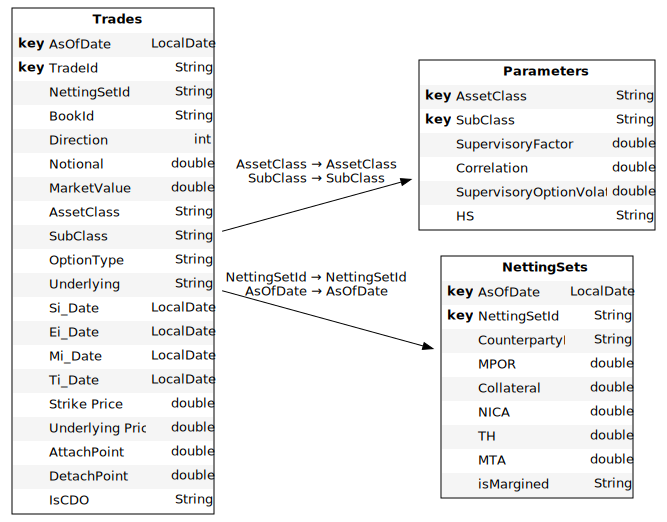

In [11]:
cube.schema

# SA-CCR calculations

In this section we will create aggregation functions (measures) to compute EAD from the input data described above.

We will proceed bottom-up  - starting with the supervisory duration metric, then move onto the trade-level adjusted notional, maturity factors, delta adjustments, addons and the necessary EAD components. 

We will keep referring to the correponding paragraphs of the [CRE52](https://www.bis.org/basel_framework/chapter/CRE/52.htm?inforce=20191215) as we progress.

## Supervisory duration - [52.34]

In this section we will compute Supervisory Duration per formula defined in CRE52 para [52.34]:

$$SupervisoryDuration = max(\text{10 business days}, \frac{(e^{-0.05*S_i} - e^{-0.05*E_i})}{0.05})$$ for Credit Spread and Interest Rates. We assume it to be equal to 1 for all other Asset Classes. 

In this expression, time period parameters are defined in [52.31] as follows:

- $S_i$ is the period of time from the valuation date until start of the time period referenced by an interest rate or credit contract
- and $E_i$ is the period of time from the valuation date until the end of the time period referenced by an interest rate or credit contract.

We will compute them from the Si and Ei dates provided in the input data.

In [12]:
number_of_days_in_year = 365

si_date_diff = (
    tt.date_diff(l["AsOfDate"], l["Si_Date"], unit="days") / number_of_days_in_year
)
ei_date_diff = (
    tt.date_diff(l["AsOfDate"], l["Ei_Date"], unit="days") / number_of_days_in_year
)

# The Si and Ei measures will be computed only for the interest rates and credit spread products.
m["Si"] = tt.filter(
    si_date_diff,
    l["AssetClass"].isin("IR", "CR_IDX", "CR_SN"),
)
m["Ei"] = tt.filter(
    ei_date_diff,
    l["AssetClass"].isin("IR", "CR_IDX", "CR_SN"),
)

# Supervisory duration is floored at 10 business dates - see [52.34]
supervisory_duration_floor = 10 / 250

# The following code will create a measure allowing us to visualize the supervisory duration
m["Supervisory_Duration"] = tt.where(
    l["AssetClass"].isin("IR", "CR_IDX", "CR_SN"),
    tt.math.max(
        (tt.math.exp(-0.05 * m["Si"]) - tt.math.exp(-0.05 * m["Ei"])) / 0.05,
        supervisory_duration_floor,
    ),
    1.0,
)
m["Supervisory_Duration"].formatter = "DOUBLE[#0,0000]"

In [13]:
# The levels required to compute Supervisory_Duration can be computed __above__ trade level, as
# the minimum required attributes are: Si_Date, Ei_Date and AssetClass.
cube.query(
    m["Supervisory_Duration"],
    m["Si"],
    m["Ei"],
    levels=[l["AssetClass"], l["Si_Date"], l["Ei_Date"]],
).head(3)

Supervisory_Duration    Si    Ei
AssetClass Si_Date    Ei_Date                                     
CO         2020-01-13 2028-01-13                  1.00  None  None
CR_IDX     2020-01-13 2025-01-13                  4.43  0.00  5.01
                      2026-01-13                  5.19  0.00  6.01

## Trade-level adjusted notional (for trade i): di - [52.34]

Having defined the Supervisory Duration measure, we'll apply it to notionals input data to obtain adjusted notional. Please review the paragraphs of the CRE52 [52.33] - [52.34] for more information on the defintinions of these formula.

$$AdjustedNotional = Notional * SupervisoryDuration$$

In [14]:
# This measure will aggregate input data - Notional Field
# We assume that all Notionals are provided in the same currency, otherwise we'd need to apply
# FX rates here.
m["Notional"] = tt.agg.sum(trades_table["Notional"])

In [15]:
# Aggregation is applied per AssetClass, Si_Date and Ei_Dates as these are the levels
# required by the Supervisory_Duration calculation.

m["Adjusted_Notional"] = tt.agg.sum(
    m["Notional"] * m["Supervisory_Duration"],
    scope=tt.scope.origin(l["AssetClass"], l["Si_Date"], l["Ei_Date"]),
)

In [16]:
cube.query(m["Adjusted_Notional"], levels=[l["TradeId"]]).head(3)

,Adjusted_Notional
TradeId,
t1,"30,000,000.00"
t10,"18,000,000.00"
t100,"9,000.00"


## Maturity factors - [52.48] - [52.53]

The Maturity Factor takes different values, depending on whether the trade is unmargined or margined:

unmargined [52.48]:

$$MF = \sqrt{\frac{min(M_i, 1year)}{1year}}$$

margined [52.52]:

$$MF = 1.5 * \sqrt{\frac{MPOR}{1 year}}$$

In the above formulae:

- $MPOR$ is the Margin Period Of Risk, provided in the input dataset, let's assume it has been provided in calendar days (not business days)
- $M_i$ is the maturity of trade $i$

In [17]:
# Measure for the input MPOR values:
m["MPOR"] = tt.value(nettingSets_table["MPOR"])

In [18]:
# This measure will compute date difference depending on the value date and the maturity date:
m["Mi"] = tt.date_diff(l["AsOfDate"], l["Mi_Date"], unit="days")

# MF_unmargined formula examples takes into account 10 days business days floor for Mi:
MF_floor = 10
MF_unmargined = tt.math.sqrt(
    tt.math.min(tt.math.max(m["Mi"], MF_floor), number_of_days_in_year)
    / number_of_days_in_year
)

# In the following calculation of MF_margined we assume that MPOR is provided in calendar days.
# Please note that this formula might need to be adjusted to incorporate floors defined in [52.50].
MF_margined = 1.5 * tt.math.sqrt(m["MPOR"] / number_of_days_in_year)


# This measure will compute maturity factor, depending on whether the trade is margined or unmargined:
m["Maturity_Factor"] = tt.agg.sum(
    tt.where(
        l["isMargined"] == "Y",
        MF_margined,
        MF_unmargined,
    ),
    scope=tt.scope.origin(l["NettingSetId"]),
)

In [19]:
# Maturity Factor requires NettingSetId and the Mi date:
cube.query(m["Maturity_Factor"], levels=[l["NettingSetId"], l["Mi_Date"]]).head(3)

Maturity_Factor
NettingSetId Mi_Date                    
EX1          2021-01-13             1.00
             2022-01-13             1.00
             2023-01-13             1.00

## Supervisory delta adjustments - [52.38] - [52.41]

Supervisory Delta takes different values depending on the nature of the instrument: 

| $\delta_i$        | Bought / Long in the primary risk factor                                          | Sold / Short in the primary risk factor                                            |
|-------------------|-----------------------------------------------------------------------------------|----------------------------------------------------------------------------------  |
| Call Options      | $+ \Phi(\frac{ln(P_i / K_i) + 0.5 * \sigma_i^2 * T_i}{\sigma_i * \sqrt{T_i}})$    | $ - \Phi(\frac{ln(P_i / K_i) + 0.5 * \sigma_i^2 * T_i}{\sigma_i * \sqrt{T_i}})$    |
| Put Options       | $- \Phi( - \frac{ln(P_i / K_i) + 0.5 * \sigma_i^2 * T_i}{\sigma_i * \sqrt{T_i}})$ | $ + \Phi( - \frac{ln(P_i / K_i) + 0.5 * \sigma_i^2 * T_i}{\sigma_i * \sqrt{T_i}})$ |
| CDO tranches      | $+ \frac{15}{(1+14*A_i)*(1+14*D_i)}$                                              | $- \frac{15}{(1+14*A_i)*(1+14*D_i)}$                                               |
| Other Instruments | $+1$                                                                              | $-1$                                                                               |

Where $\Phi$ is the standard normal cumulative distribution function,

- $P_i$ is the Underlying Price of trade $i$,
- $K_i$ is the Strike Price of trade $i$,
- $\sigma_i$ is the Supervisory Volatility of trade $i$,
- $T_i$ is the latest contractual exercise date of the option $i$
- $A_i$ is the Attachment Point of the CDO tranche $i$
- and $D_i$ is the Detachment Point of the CDO tranche $i$

Delta adjustment will be applied to trade-level effective notional, together with maturity factor to obtain effective notional. We'll define Delta adjustment for any trade as product of:

- Long/Short indicator: 1 or -1
- Delta adjustment for call options or 1 - `call_multiplier`,
- Delta adjustment for put options or 1 - `put_multiplier`,
- CDO adjustment or 1 - `cdo_multiplier`.

Let's start by adding measures displaying input data:

In [20]:
m["SupervisoryOptionVolatility.VALUE"] = tt.value(
    supervisoryParameters_table["SupervisoryOptionVolatility"], levels=[l["TradeId"]]
)

In [21]:
# Measures displaying trade parameters (input data):
m["Underlying Price"] = tt.value(
    trades_table["Underlying Price"], levels=[l["TradeId"]]
)
m["Strike Price"] = tt.value(trades_table["Strike Price"], levels=[l["TradeId"]])
m["AttachPoint"] = tt.value(trades_table["AttachPoint"], levels=[l["TradeId"]])
m["DetachPoint"] = tt.value(trades_table["DetachPoint"], levels=[l["TradeId"]])

And this measure will display 1/-1 for long/short positions.

In [22]:
m["Direction"] = tt.value(trades_table["Direction"])

Let's move onto computing options delta adjustment. To compute time to expiry in years from trade's expiry date attribute, we can use the following syntax:

In [23]:
# Computing time period until options' expiry Ti:
m["Ti"] = (
    tt.date_diff(l["AsOfDate"], l["Ti_Date"], unit="days") / number_of_days_in_year
)

In [24]:
# We'll wrap the argument of the CDF function into a measure:
m["d"] = (
    tt.math.log(m["Underlying Price"] / m["Strike Price"])
    + 0.5 * (m["SupervisoryOptionVolatility.VALUE"] ** 2) * m["Ti"]
) / (m["SupervisoryOptionVolatility.VALUE"] * tt.math.sqrt(m["Ti"]))

In [25]:
cube.query(
    m["d"],
    levels=[l["TradeId"], l["Ti_Date"]],
    condition=l["OptionType"].isin("C", "P"),
).head(3)

,,d
TradeId,Ti_Date,
t111,2020-04-13,0.15
t118,2020-02-13,0.18
t126,2020-04-13,0.53


Finally, the call and put multipliers can be defined as follows:

In [26]:
call_multiplier = tt.where(
    l["OptionType"] == "C",
    tt.experimental.stats.normal.cdf(m["d"], mean=0, standard_deviation=1),
    1.0,
)

put_multiplier = tt.where(
    l["OptionType"] == "P",
    -tt.experimental.stats.normal.cdf(-m["d"], mean=0, standard_deviation=1),
    1.0,
)

Using the "AttachPoint" and "DetachPoint" values, the delta adjustment for CDO positions can be defined as follows:

In [27]:
cdo_multiplier = tt.where(
    l["IsCDO"] == "Y",
    15.0 / ((1.0 + 14.0 * m["AttachPoint"]) * (1.0 + 14.0 * m["DetachPoint"])),
    1.0,
)

Using product of the above multipliers we will define the combined Delta Adjustment measure:

In [28]:
m["Delta_Adjustment"] = (
    m["Direction"] * call_multiplier * put_multiplier * cdo_multiplier
)

## Trade Effective Notional - [52.30]

Bringing the trade effective notional components together and calculating on trade level:

In [29]:
m["Trade_Effective_Notional"] = tt.agg.sum(
    m["Adjusted_Notional"] * m["Delta_Adjustment"] * m["Maturity_Factor"],
    scope=tt.scope.origin(
        l["TradeId"],
        l["NettingSetId"],
        l["OptionType"],
        l["Mi_Date"],
        l["IsCDO"],
        l["Ti_Date"],
    ),
)

In [30]:
cube.query(
    m["Trade_Effective_Notional"],
    m["Adjusted_Notional"],
    m["Delta_Adjustment"],
    m["Maturity_Factor"],
    levels=[
        l["TradeId"],
        l["OptionType"],
        l["Mi_Date"],
        l["IsCDO"],
        l["Ti_Date"],
    ],
).head(3)

,,,,,Trade_Effective_Notional,Adjusted_Notional,Delta_Adjustment,Maturity_Factor
TradeId,OptionType,Mi_Date,IsCDO,Ti_Date,,,,
t1,N/A,2024-01-13,N,2028-01-13,"-30,000,000.00","30,000,000.00",-1.00,1.00
t10,N/A,2024-01-13,N,2028-01-13,"18,000,000.00","18,000,000.00",1.00,1.00
t100,N/A,2055-01-13,N,2028-01-13,"9,000.00","9,000.00",1.00,1.00


## Asset class level add-ons - [52.55]

Having obtained the trade effective notionals reflecting the necessary supervisory adjustments, we can use them to compute AddOns for each of the five asset classes.

## Add-on for interest rate derivatives - [52.56]

The steps for computing $Addon^{IR}$ are set in [52.57].


- For Interest Rates, each Hedging Set is defined as currency - in our data model it comes from the field Underlying. 
- Each hedge set is then separated in maturity buckets depending on $M_i$. If $M_i$ is less than one year, the trade goes in the first Maturity Bucket, if it is between one and five years, the trade goes in the second Maturity Bucket, and if it is more than 5 years the trade goes in the third Maturity Bucket.
- In each Maturity Bucket and each Hedging Set, the effective notional is the sum of the Trade Effective Notionals of the trades. 

The effective notional $EN_{HS}$ of the Hedge Set $HS$ is then determined with the following formula :

$$EN_{HS} = ( D_{B1}^2 + D_{B2}^2 + D_{B3}^2 + 1.4 * D_{B1} * D_{B2} + 1.4 * D_{B2} * D_{B3} + 0.6 * D_{B1} * D_{B3} )^{\frac{1}{2}}$$


In [31]:
# Step 1 Filtering the trade effective notionals of the Interest rate risk class only:
m["Effective_notional_IR"] = tt.filter(
    m["Trade_Effective_Notional"], l["AssetClass"] == "IR"
)

In [32]:
# Step 2 Allocating trades into Hedging Sets - for IR we'll use "RiskFactorCcy" as Hedging Set.

In [33]:
cube.query(m["Effective_notional_IR"])

,Effective_notional_IR
0,"2,949,671,733.30"


In [34]:
# Step 3 Allocating trades into Maturity Buckets and
# Step 4 Adding together effective notionals

# We use tt.where condition and filtering for the effective notional buckets -  D_B1, D_B2, D_b3
# Ei is computed from the Ei_Date attribute, hence we are summing up by Ei_Date.
m["D_B1"] = tt.agg.sum(
    tt.where(m["Ei"] < 1.0, m["Effective_notional_IR"], 0.0),
    scope=tt.scope.origin(l["Ei_Date"]),
)

m["D_B2"] = tt.agg.sum(
    tt.where((m["Ei"] >= 1.0) & (m["Ei"] < 5.0), m["Effective_notional_IR"], 0.0),
    scope=tt.scope.origin(l["Ei_Date"]),
)

m["D_B3"] = tt.agg.sum(
    tt.where(m["Ei"] >= 5.0, m["Effective_notional_IR"], 0.0),
    scope=tt.scope.origin(l["Ei_Date"]),
)

In [35]:
cube.query(m["Effective_notional_IR"], m["D_B1"], m["D_B2"], m["D_B3"])

,Effective_notional_IR,D_B1,D_B2,D_B3
0,"2,949,671,733.30","629,383.05",.00,"2,949,042,350.25"


In [36]:
cube.query(m["Ei"], levels=[l["TradeId"], l["Ei_Date"]]).sample(3)

,,Ei
TradeId,Ei_Date,
t88,2032-01-13,12.01
t249,2027-01-13,7.01
t55,2034-01-13,14.01


In [37]:
# Step 5 Calculating effecting notional of the hedging set - and summing them up across hedging sets.
# As a reminder, a hedging set is a combination of RiskFactorCcy and Underlying fields for interest rates:

m["Effective_notional_IR_Offset_Formula"] = tt.agg.sum(
    tt.math.sqrt(
        m["D_B1"] ** 2
        + m["D_B2"] ** 2
        + m["D_B3"] ** 2
        + 1.4 * m["D_B1"] * m["D_B2"]
        + 1.4 * m["D_B2"] * m["D_B3"]
        + 0.6 * m["D_B1"] * m["D_B3"]
    ),
    scope=tt.scope.origin(l["Underlying"]),
)

m["Effective_notional_IR_NoOffset_Formula"] = tt.agg.sum(
    tt.math.abs(m["D_B1"]) + tt.math.abs(m["D_B2"]) + tt.math.abs(m["D_B3"]),
    scope=tt.scope.origin(l["Underlying"]),
)

The Add-On for each hedge set is then simply : 

$$AddOn_{j}^{(IR)} = SF^{(IR)} * EN_j $$

Let's display the Supervisory Factor:

In [38]:
m["SupervisoryFactor"] = tt.value(
    supervisoryParameters_table["SupervisoryFactor"], levels=[l["AsOfDate"]]
)
# You may want to further adjust the Supervisory Factor by checking if the trade is a "basis" trade
# please see [52.46]. In our case, we don't account for that.

cube.query(
    m["SupervisoryFactor"],
    levels=[l["AsOfDate"]],
    condition=l["AssetClass"] == "IR",
)

,SupervisoryFactor
AsOfDate,
2020-01-13,.01


Finally, the AddOn:

In [39]:
m["AddOn_IR"] = tt.agg.sum(
    m["SupervisoryFactor"] * m["Effective_notional_IR_Offset_Formula"],
    scope=tt.scope.origin(l["AssetClass"]),
)
# Use No Offset Formula here if the bank chose not to recognize netting
m["AddOn_IR_NoOffset_Formula"] = tt.agg.sum(
    m["SupervisoryFactor"] * m["Effective_notional_IR_NoOffset_Formula"],
    scope=tt.scope.origin(l["AssetClass"]),
)

## Add-on for credit derivatives - [52.60] - [52.64]

There is only one Hedge Set for Credit derivatives. In this Hedge Set, the trades are grouped depending on which entity issued them. The Add-On for an entity is the sum of the Trade Effective Notionals of the corresponding trades, multiplied by the Supervisory Factor. The Supervisory Factor depends on the rating of the entity. 


In [40]:
effective_notional_CR = tt.filter(
    m["Trade_Effective_Notional"], l["AssetClass"].isin("CR_IDX", "CR_SN")
)


# summing up by AssetClass and SubClass as these are the levels where SupervisoryFactors are defined:
m["AddOn_CR_per_entity"] = tt.agg.sum(
    m["SupervisoryFactor"] * effective_notional_CR,
    scope=tt.scope.origin(l["AssetClass"], l["SubClass"]),
)

After determining the AddOn per entity, we can deduce the Credit AddOn with the following formula  - see para [52.61] :

$$ AddOn^{Credit} = \left[\left(\sum_{entity} \rho_{entity} *  AddOn_{entity} \right)^{2} + \sum_{entity} (1-(\rho_{entity})^{2}) *  (AddOn_{entity})^{2} \right]^{1/2}$$

where $\rho_{entity}$ is the Correlation. It takes different values for names being Credit Single Name or Credit Index.

In [41]:
m["Correlation"] = tt.value(
    supervisoryParameters_table["Correlation"], levels=[l["AssetClass"]]
)
cube.query(m["Correlation"], levels=[l["AssetClass"]])

,Correlation
AssetClass,
CO,.40
CR_IDX,.80
CR_SN,.50
EQ_SN,.50


In [42]:
# The first term of the above formula:
AddOn_CR_systematic = (
    tt.agg.sum(
        m["Correlation"] * m["AddOn_CR_per_entity"],
        scope=tt.scope.origin(l["Underlying"]),
    )
    ** 2
)

# The second term of the above formula:
AddOn_CR_idiosyncratic = tt.agg.sum(
    (1.0 - (m["Correlation"] ** 2)) * (m["AddOn_CR_per_entity"] ** 2),
    scope=tt.scope.origin(l["Underlying"]),
)

m["AddOn_CR"] = tt.math.sqrt(AddOn_CR_systematic + AddOn_CR_idiosyncratic)

## Add-on for commodity derivatives - [52.69] - [52.71]

Commodities are broken down into 4 Hedging Sets (hierarchy "HS"): Energy, Metals, Agricultural and Others. Inside these Hedging Sets, the trades are grouped by commodity type - in our data model this is represented by the "SubClass" field.

The main formulae and step-by-step instruction is provided in the [52.70]:

$$ AddOn_{HS}^{CO} = \left[\left(\sum_{CommType} \rho_{CommType}\cdot AddOn_{CommType}\right)^{2} + \sum_{CommType}  (1-\rho_{CommType}^2)* AddOn_{CommType}^{2} \right]^{1/2}$$

$$AddOn^{CO} = \sum_{HS}AddOn_{HS}^{CO}$$


In [43]:
# Step 3 Calculate the combined effective notional
effective_notional_CO = tt.filter(
    m["Trade_Effective_Notional"], l["AssetClass"] == "CO"
)

# Step 4 Calculate the add-on for each commodity type
AddOn_CommType = tt.agg.sum(
    m["SupervisoryFactor"] * effective_notional_CO,
    scope=tt.scope.origin(l["AssetClass"], l["SubClass"]),
)

In [44]:
# Step 5
# The first term of the above formula:
AddOn_CO_systematic = (
    tt.agg.sum(
        m["Correlation"] * AddOn_CommType,
        scope=tt.scope.origin(l["SubClass"]),
    )
    ** 2
)

# The second term of the above formula:
AddOn_CO_idiosyncratic = tt.agg.sum(
    (1.0 - (m["Correlation"] ** 2)) * (AddOn_CommType**2),
    scope=tt.scope.origin(l["SubClass"]),
)

# Generic measure computing the product
AddOn_CO_HS = tt.math.sqrt(AddOn_CO_systematic + AddOn_CO_idiosyncratic)

# Add on as a sum of products over all hedging sets
m["AddOn_CO"] = tt.agg.sum(AddOn_CO_HS, scope=tt.scope.origin(l["HS"]))

In [45]:
cube.query(m["AddOn_CO"], levels=[l["HS"]])

,AddOn_CO
HS,
Agricultural,"6,120,000.00"
Energy,"43,007,147.78"
Metals,"10,154,326.76"
Other,"12,084,520.96"


## Add-on for foreign exchange derivatives - [52.58] - [52.59]

Step-by-step instruction for calculating $AddOn^{FX}$ are provided in the [52.59]. Hedging sets - are different currency pairs, which can be found in the field "Underlying" in our data model.

Let's jump to Step 4 and compute $AddOn_{HS}^{FX} = | EN_{HS} | \cdot SF$

In [46]:
EN_HS_FX = tt.filter(
    m["Trade_Effective_Notional"],
    l["AssetClass"] == "FX",
)


# Step 5: Sum up across absolute values of EN_HS multiplied by supervisory factor by currency pairs:
m["AddOn_FX"] = tt.agg.sum(
    tt.math.abs(EN_HS_FX) * m["SupervisoryFactor"],
    scope=tt.scope.origin(l["Underlying"]),
)

In [47]:
cube.query(
    m["AddOn_FX"],
    m["Trade_Effective_Notional"],
    m["SupervisoryFactor"],
    levels=[l["Underlying"]],
    condition=l["AssetClass"] == "FX",
).sample(3)

,AddOn_FX,Trade_Effective_Notional,SupervisoryFactor
Underlying,,,
CADNZD,"2,840,000.00","71,000,000.00",0.04
JPYEUR,"411,292.09","-10,282,302.37",0.04
JPYUSD,"2,127,022.47","53,175,561.72",0.04


## Add-on for equity derivatives - [52.65] - [52.68]

Equity Add-On is determined in the same way as Credit Add-On. The trades are grouped under a single Hedge Set, and grouped by entity inside. However, the supervisory factor no longer depends on the rating of the entity but rather on wether the trade's Asset Class is Equity Index or Equity Single Name. The formula for the Equity Addon is defined in para [52.66]:


$$ AddOn^{Equity} = \left[\left(\sum_{entity} \rho_{entity}\cdot AddOn_{entity}\right)^{2} + \sum_{entity}  (1-\rho_{entity}^2)* AddOn_{entity}^{2} \right]^{1/2}$$



where $\rho_{k}$ is the correlation factor corresponding to entity k


In [48]:
AddOn_EQ_entity = tt.filter(
    m["SupervisoryFactor"] * m["Trade_Effective_Notional"],
    l["AssetClass"].isin("EQ_SN", "EQ_IDX"),
)

In [49]:
AddOn_EQ_systematic = tt.agg.sum(
    (m["Correlation"] * AddOn_EQ_entity) ** 2,
    scope=tt.scope.origin(l["Underlying"]),
)

AddOn_EQ_idiosyncratic = tt.agg.sum(
    (1.0 - (m["Correlation"] ** 2)) * (AddOn_EQ_entity**2),
    scope=tt.scope.origin(l["Underlying"]),
)

m["AddOn_EQ"] = tt.math.sqrt(AddOn_EQ_systematic + AddOn_EQ_idiosyncratic)

In [50]:
cube.query(m["AddOn_EQ"])

,AddOn_EQ
0,"21,117.42"


## Aggregate add-on - [52.24]

The Add-on aggregate is simply the sum of all five Asset Class Add-Ons:

In [51]:
# This measure will be displaying aggregate AddOn
m["AddOn"] = (
    m["AddOn_CR"] + m["AddOn_IR"] + m["AddOn_CO"] + m["AddOn_FX"] + m["AddOn_EQ"]
)

In [52]:
cube.query(
    m["AddOn"],
    m["AddOn_CR"],
    m["AddOn_IR"],
    m["AddOn_CO"],
    m["AddOn_FX"],
    m["AddOn_EQ"],
)

,AddOn,AddOn_CR,AddOn_IR,AddOn_CO,AddOn_FX,AddOn_EQ
0,"337,264,378.54","189,030,872.50","18,489,820.57","71,365,995.50","58,356,572.54","21,117.42"


## Multiplier - [52.23]

In this section we will compute the multiplier, defined per formula:
    
$$multiplier = min(1, Floor + (1-Floor)*exp(\frac{V-C}{2*(1-Floor)*AddOn^{aggregate}}))$$ 

(where $Floor = 0.05$ is another fixed parameter)

In [53]:
# Let's display V - value of the positions:
m["MarketValue"] = tt.agg.sum(trades_table["MarketValue"])

# Let's also display C - value of collateral (after haircut) - from the input data
m["Collateral"] = tt.agg.sum(nettingSets_table["Collateral"])

In [54]:
floor = 0.05
alpha = 1.4
m["Multiplier"] = tt.agg.sum(
    tt.math.min(
        1.0,
        floor
        + (1 - floor)
        * tt.math.exp(
            (m["MarketValue"] - m["Collateral"]) / (2 * (1 - floor) * m["AddOn"])
        ),
    ),
    scope=tt.scope.origin(l["NettingSetId"]),
)

In [55]:
cube.query(m["Multiplier"], levels=[l["NettingSetId"]]).sample(3)

,Multiplier
NettingSetId,
EX2,1.00
EX9,1.00
EX7,1.00


## PFE add-on for each netting set - [52.20]

Having defined the aggregate AddOn and the multiplier, the PFE is obtained per formula: $PFE = multiplier * AddOn^{aggregate}$  - which is computed for each netting set and then summed up.

In [56]:
m["PFE"] = tt.agg.sum(
    m["Multiplier"] * m["AddOn"], scope=tt.scope.origin(l["NettingSetId"])
)

In [57]:
cube.query(m["PFE"])

,PFE
0,"637,681,350.88"


## Replacement cost - [52.10] - [52.18]

The Replacement Cost is $RC = max(V-C,0)$  for unmargined transactions and $RC = max(V-C, TH + MTA - NICA, 0)$. 

In this formula:

- $V$ is the market value of derivative transactions, 
- $C$ is the haircut value of net collateral held (if any)), 
- TH - positive threshold before the counterparty must send the bank collateral, 
- MTA - minimum transfer amount applicable to the counterparty, 
- NICA - net independent collateral amount.

In [58]:
# Let's start by disaplying TH, MTA and NICA parameters of netting sets:
m["TH"] = tt.value(nettingSets_table["TH"])
m["MTA"] = tt.value(nettingSets_table["MTA"])
m["NICA"] = tt.value(nettingSets_table["NICA"])
cube.query(m["TH"], m["MTA"], m["NICA"], levels=[l["NettingSetId"]])

,TH,MTA,NICA
NettingSetId,,,
EX10,.00,"5,000.00","170,388.00"


In [59]:
RC_unmargined = tt.math.max(m["MarketValue"] - m["Collateral"], 0)

RC_margined = tt.math.max(
    m["MarketValue"] - m["Collateral"],
    m["TH"] + m["MTA"] - m["NICA"],
    0,
)

m["RC"] = tt.agg.sum(
    tt.where(
        l["isMargined"] == "Y",
        RC_margined,
        RC_unmargined,
    ),
    scope=tt.scope.origin(l["NettingSetId"]),
)

In [60]:
cube.query(m["RC"], m["MarketValue"], m["Collateral"], levels=[l["isMargined"]])

,RC,MarketValue,Collateral
isMargined,,,
N,"885,078,290.00","885,078,290.00",.00
Y,"157,771,095.00","168,903,160.00","11,132,065.00"


# EAD - [52.1]

$$EAD = \alpha * (RC + PFE)$$

where $alpha = 1.4$ (fixed parameter), 

In [61]:
alpha = 1.4
m["EAD"] = tt.agg.sum(
    alpha * (m["RC"] + m["PFE"]), scope=tt.scope.origin(l["NettingSetId"])
)

# Formatting

The following cell will allocate measures to folders in the cube explorer, and apply formatting.

In [62]:
for measure in sorted(list(m)):
    if (
        measure.startswith("AddOn")
        or measure.startswith("D_")
        or measure
        in [
            "Effective_notional_IR_NoOffset_Formula",
            "Effective_notional_IR_Offset_Formula",
            "Effective_notional_IR_j_k",
            "Effective_notional_IR",
        ]
    ):
        m[measure].formatter = "DOUBLE[#,###]"
        m[measure].folder = "AddOn"
    elif measure in [
        "Correlation",
        "SupervisoryFactor",
        "Supervisory_Option_Volatility",
    ]:
        m[measure].formatter = "DOUBLE[#,###.0000]"
        m[measure].folder = "Supervisory Parameters"

    elif measure in [
        "Direction",
        "DetachPoint",
        "AttachPoint",
        "MarketValue",
        "Notional",
        "Underlying Price",
        "Strike Price",
    ]:
        m[measure].formatter = "DOUBLE[#,###.0000]"
        m[measure].folder = "Trades Input Data"

    elif measure in ["Collateral", "TH", "MTA", "NICA", "MPOR"]:
        m[measure].formatter = "DOUBLE[#,###]"
        m[measure].folder = "Netting Sets Input Data"

    elif measure in ["Mi", "Ei", "Si", "Ti"]:
        m[measure].formatter = "DOUBLE[#,###.##]"
        m[measure].folder = "Time period parameters"

    elif measure in [
        "Delta_Adjustment",
        "Supervisory_Duration",
        "Adjusted_Notional",
        "Maturity_Factor",
        "d",
        "Trade_Effective_Notional",
        "Adjusted_Notional x Delta_Adjustment",
    ]:
        m[measure].formatter = "DOUBLE[#,###.00]"
        m[measure].folder = "Derived Interim Results"
    m["EAD"].formatter = "DOUBLE[#,###]"
    m["PFE"].formatter = "DOUBLE[#,###]"
    m["RC"].formatter = "DOUBLE[#,###]"

# Enriching the data

Having implemented the core metrics for computing EAD from trades data and parameters, we can enrich trades and netting sets data with additional attributes. As an example, let's load business units and link them to trades via book:

In [63]:
books_table = session.read_csv(
    "s3://data.atoti.io/notebooks/sa-ccr/T0/books.csv",
    keys=["AsOfDate", "BookId"],
    table_name="BookStructure",
)

trades_table.join(books_table, mapping={"BookId": "BookId", "AsOfDate": "AsOfDate"})

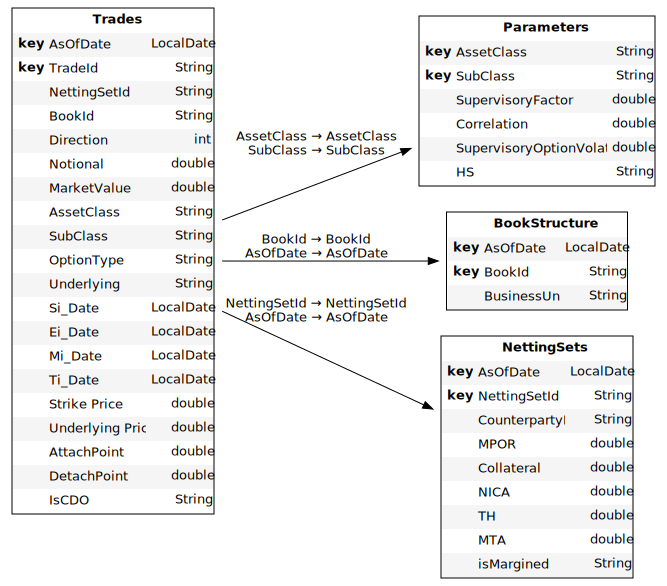

In [64]:
cube.schema

Breaking down EAD by organizational structure, for example by book we'll obtain standalone calculation for each book. Since the EAD aggregation is not linear, sum of elements is not equal to the calculation across Books. Continue reading to learn how to create measures for contribution analysis.

In [65]:
sum(cube.query(m["EAD"], levels=[l["BookId"]])["EAD"])

3190859675.5486293

In [66]:
cube.query(m["EAD"])

,EAD
0,"2,352,743,030"


# Pro-rata allocation

In the previous section we saw that breaking EAD down by book will result in "standalone" calculations, and since EAD is a non-linear measure, sum of EAD by book is not equal to the EAD calculated for the global portfolio. We may want to implement an allocation methodology for EAD. There multiple methodologies you could choose for evaluating the contribution, let's use "pro-rata" allocation as an illustrative example.

The measure "EAD Pro-Rata" will display the contribution of a business unit into EAD for the global portfolio based on the proportion of EAD for that unit and sum of EADs for all units.

In [67]:
# For each Book, the weight is a ratio of EAD and EAD across books.
m["EAD_sum_by_book"] = tt.agg.sum(m["EAD"], scope=tt.scope.siblings(h["BookId"]))
m["Book_weight"] = m["EAD"] / m["EAD_sum_by_book"]
m["EAD_across_books"] = tt.parent_value(
    m["EAD"],
    degrees={h["BookId"]: 1},
    total_value=m["EAD"],
    apply_filters=True,
)

m["EAD Pro-Rata"] = m["Book_weight"] * m["EAD_across_books"]

In [68]:
session.link()

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

# Simulations

atoti provides a powerful simulation framework. 

Below we will explore a few examples of uploading alternative data into our app to instantly see the impact on the capital charge metrics.

### Simulation on supervisory parameters  

As a reminder, the Supervisory Option Volatility is a parameter in the Delta Adjustment calculation. Let's bring up the values using cube.query:

In [69]:
cube.query(
    m["SupervisoryOptionVolatility.VALUE"], levels=[l["AssetClass"], l["SubClass"]]
)

,SupervisoryOptionVolatility.VALUE


"[Parameter simulations](https://docs.atoti.io/latest/tutorial/tutorial.html#Parameter-simulations)" feature in atoti allow us to configure a simulated measure, `Supervisory_Option_Volatility_Simulation`.  

In [70]:
recalibration = cube.create_parameter_simulation(
    "Option Volatility What-If",
    measures={"Supervisory_Option_Volatility_Simulation": None},
    levels=[l["AssetClass"], l["SubClass"]],
)

To make use of the simulated measure, we create the following measure that takes the value of `Supervisory_Option_Volatility_Simulation` if it is provided. Otherwise, it takes the volatility values in the original dataset.

In [71]:
m["Supervisory_Option_Volatility"] = tt.agg.sum(
    tt.where(
        m["Supervisory_Option_Volatility_Simulation"] != None,
        m["Supervisory_Option_Volatility_Simulation"],
        m["SupervisoryOptionVolatility.VALUE"],
    ),
    scope=tt.scope.origin(l["AssetClass"], l["SubClass"]),
)

We are going to update the definition of the measure `d` to use the new simulated `Supervisory_Option_Volatility` instead. This change will automatically be cascaded to the measures that uses `d` in their computation.

In [72]:
# We'll wrap the argument of the CDF function into a measure:
m["d"] = (
    tt.math.log(m["Underlying Price"] / m["Strike Price"])
    + 0.5 * (m["Supervisory_Option_Volatility"] ** 2) * m["Ti"]
) / (m["Supervisory_Option_Volatility"] * tt.math.sqrt(m["Ti"]))

__Note:__ We could planned in advance and create the parameter simulation for "Option Volatility What-If" before we first defined the measure `d`. This would prevent the need to update `d` definition. However, the current setup in the notebook is meant to demonstrate the difference with and without the parameter simulation.

Having setup the simulation, we apply the changes we want in our experiment.  

The first input parameter is the name of the scenario, followed by the affected members of the specified levels and finally the new value of `Supervisory_Option_Volatility_Simulation`.

In [73]:
recalibration += ("Volatility Recalibration", "IR", "No SubClass", 0.1)

In [74]:
recalibration.head()

,,,Supervisory_Option_Volatility_Simulation
SubClass,AssetClass,Scenario,
No SubClass,IR,Volatility Recalibration,0.10


The below query shows the value that is used for `Supervisory_Option_Volatility` to compute the measure `d`.

In [75]:
cube.query(
    m["SupervisoryOptionVolatility.VALUE"],
    m["Supervisory_Option_Volatility_Simulation"],
    m["Supervisory_Option_Volatility"],
    levels=[
        l["TradeId"],
        l["AssetClass"],
        l["SubClass"],
        l["Option Volatility What-If"],
    ],
    condition=l["AssetClass"] == "IR",
)

SupervisoryOptionVolatility.VALUE  \
TradeId AssetClass SubClass    Option Volatility What-If                                     
t11     IR         No SubClass Base                                                    .50   
                               Volatility Recalibration                                .50   
t111    IR         No SubClass Base                                                    .50   
                               Volatility Recalibration                                .50   
t113    IR         No SubClass Base                                                    .50   
...                                                                                    ...   
t88     IR         No SubClass Volatility Recalibration                                .50   
t91     IR         No SubClass Base                                                    .50   
                               Volatility Recalibration                                .50   
t93     IR         No SubClass Base                                                    .50   
                               Volatility Recalibration                                .50   

                                                         Supervisory_Option_Volatility_Simulation  \
TradeId AssetClass SubClass    Option Volatility What-If                                            
t11     IR         No SubClass Base                                                                 
                               Volatility Recalibration                                       .10   
t111    IR         No SubClass Base                                                                 
                               Volatility Recalibration                                       .10   
t113    IR         No SubClass Base                                                                 
...                                                                                           ...   
t88     IR         No SubClass Volatility Recalibration                                       .10   
t91     IR         No SubClass Base                                                                 
                               Volatility Recalibration                                       .10   
t93     IR         No SubClass Base                                                                 
                               Volatility Recalibration                                       .10   

                                                         Supervisory_Option_Volatility  
TradeId AssetClass SubClass    Option Volatility What-If                                
t11     IR         No SubClass Base                                                .50  
                               Volatility Recalibration                            .10  
t111    IR         No SubClass Base                                                .50  
                               Volatility Recalibration                            .10  
t113    IR         No SubClass Base                                                .50  
...                                                                                ...  
t88     IR         No SubClass Volatility Recalibration                            .10  
t91     IR         No SubClass Base                                                .50  
                               Volatility Recalibration                            .10  
t93     IR         No SubClass Base                                                .50  
                               Volatility Recalibration                            .10  

[198 rows x 3 columns]

Below we see the dfference in the `EAD` and `AddOn_IR` values between the original base data and the simulated scenario `Volatility Recalibration`.

In [76]:
cube.query(m["EAD"], m["AddOn_IR"], levels=[l["Option Volatility What-If"]])

,EAD,AddOn_IR
Option Volatility What-If,,
Base,"2,352,743,030","18,489,821"
Volatility Recalibration,"2,354,807,306","18,105,387"


# Simulation on input data - trades and CSA simulations

The "source simulation" in atoti allow uploading data and viewing the resulting change side-by-side with the base scenario. This is handy for "pre-deal", "trade novation" or "aggrement changes" types of simulations where you can use a csv file to add or update positions and netting sets.

See, for instance, the parameters of the first netting set:

Let's change the parameters of this agreement:

In [77]:
from datetime import date

agreement_update = pd.DataFrame.from_dict(
    {
        "AsOfDate": [date(2020, 1, 13)],
        "NettingSetId": ["EX1"],
        "CounterpartyId": ["cpt1"],
        "MPOR": [15.0],
        "Collateral": [1000000.0],
        "NICA": [0],
        "TH": [0],
        "MTA": [0],
        "isMargined": ["Y"],
    }
)
agreement_update

,AsOfDate,NettingSetId,CounterpartyId,MPOR,Collateral,NICA,TH,MTA,isMargined
0,2020-01-13,EX1,cpt1,15.00,"1,000,000.00",0,0,0,Y


In [78]:
nettingSets_table.scenarios["Updating CSA parameters"].load_pandas(agreement_update)

In [79]:
session.link(path="/#/dashboard/922")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

# Adding more dates

In [80]:
trades_table.load_csv("s3://data.atoti.io/notebooks/sa-ccr/T1/trades.csv")
books_table.load_csv("s3://data.atoti.io/notebooks/sa-ccr/T1/books.csv")
nettingSets_table.load_csv(
    "s3://data.atoti.io/notebooks/sa-ccr/T1/netting-set-attributes.csv"
)

<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=saccr" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="atoti table" /></a></div>